In [1]:
import csv

import datetime
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

# Data Visualiation
import matplotlib.pyplot as plt
import seaborn as sns

# System
import os

# Deep Learning

from typing import Dict, List, Tuple, Sequence


### Get processed data

In [2]:
file_path="~/code/Agermita/intelligent_network_expansion/raw_data/data_finale_V4.csv"

processed_data = pd.read_csv(file_path, sep=',')
processed_data.columns

Index(['Unnamed: 0', 'Date', 'eNodeB identity', 'Cell ID', 'Trafic LTE.float',
       'L.Traffic.ActiveUser.Avg.float', 'L.Traffic.User.Avg.float',
       'DL throughput_GRP.float', 'DL PRB Usage.float',
       'eNodeB_identifier_int', 'Trafic LTE.float.scaled',
       'Cell FDD TDD Indication_CELL_FDD', 'Cell FDD TDD Indication_CELL_TDD',
       'Downlink EARFCN_Band_1', 'Downlink EARFCN_Band_2',
       'Downlink EARFCN_Band_3', 'Downlink EARFCN_Band_4',
       'Downlink EARFCN_Band_5', 'Downlink bandwidth_CELL_BW_N100',
       'Downlink bandwidth_CELL_BW_N50', 'LTECell Tx and Rx Mode_1T1R',
       'LTECell Tx and Rx Mode_2T2R', 'LTECell Tx and Rx Mode_2T4R',
       'LTECell Tx and Rx Mode_4T4R', 'LTECell Tx and Rx Mode_8T8R',
       'City_City_1', 'City_City_3', 'City_City_4', 'City_City_5',
       'City Type_Rural', 'City Type_Urbain', 'City Type_Urbain dense'],
      dtype='object')

In [3]:
processed_data.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
processed_data['Trafic LTE.float'].max()

685.8797

In [5]:
processed_data['Date'] = pd.to_datetime(processed_data['Date'], format='%Y-%m-%d')
processed_data.dtypes

Date                                datetime64[ns]
eNodeB identity                              int64
Cell ID                                      int64
Trafic LTE.float                           float64
L.Traffic.ActiveUser.Avg.float             float64
L.Traffic.User.Avg.float                   float64
DL throughput_GRP.float                    float64
DL PRB Usage.float                         float64
eNodeB_identifier_int                        int64
Trafic LTE.float.scaled                    float64
Cell FDD TDD Indication_CELL_FDD           float64
Cell FDD TDD Indication_CELL_TDD           float64
Downlink EARFCN_Band_1                     float64
Downlink EARFCN_Band_2                     float64
Downlink EARFCN_Band_3                     float64
Downlink EARFCN_Band_4                     float64
Downlink EARFCN_Band_5                     float64
Downlink bandwidth_CELL_BW_N100            float64
Downlink bandwidth_CELL_BW_N50             float64
LTECell Tx and Rx Mode_1T1R    

### create train, val and split based on time split

In [6]:
def get_cells_data(df) ->np.array :
    cells=df[["eNodeB identity",'Cell ID','eNodeB_identifier_int']].sort_values(by='eNodeB_identifier_int')
    cells=cells.drop_duplicates()
    cells_2=cells.iloc[:500]  # to limit to first 200 CELLS

    data=[]
    data_trafic=[]
    for index, row in cells_2.iterrows():
        df_cell=df[(df["eNodeB identity"]==row[0]) & (df["Cell ID"]==row[1])]
        df_cell=df_cell.sort_values(by='eNodeB_identifier_int')
        df_cell=df_cell.reset_index(drop=True)
        df_cell_1=df_cell.copy()
        df_cell_1.drop(['Date','eNodeB identity', 'Cell ID', 'eNodeB_identifier_int'], axis=1, inplace=True)

        df_cell_trafic=df[(df["eNodeB identity"]==row[0]) & (df["Cell ID"]==row[1])]
        df_cell_trafic=df_cell.sort_values(by='eNodeB_identifier_int')
        df_cell_trafic=pd.DataFrame(df_cell.reset_index(drop=True))

        df_cell_trafic=df_cell_trafic["Trafic LTE.float"]

        data.append(df_cell_1)
        data_trafic.append(df_cell_trafic)

    cells_data=np.array(data)
    cells_data_trafic=np.array(data_trafic)

    return cells_2, cells_data, cells_data_trafic

In [7]:
cells, cells_data, cells_data_trafic=get_cells_data(processed_data)

In [ ]:
cells_data_trafic.shape

In [8]:
def train_test_val_split(data_cell:pd.DataFrame,
                     output_length: int) -> Tuple[pd.DataFrame]:
    """From a cell data (dataframe), take a train dataframe, validation dataframe
     and test dataframe then split them to X and y using a fixed output_length


    Args:
        data_cell (pd.DataFrame): chronological data of one cell
        train_test_ratio (float): The ratio between train and test 0-1
        input_length (int): How long each X_i will be : 3 month 90 days

    Returns:
        Tuple[pd.DataFrame]: A tuple of 6 dataframes (X_train, y_train, X_val, y_val, X_test, y_test)
    """
    # $CHALLENGIFY_BEGIN

    # TRAIN SET
    # ======================
    X_train_index_last = round(len(data_cell)-3*output_length)

    X_train=pd.DataFrame(data_cell.iloc[0:X_train_index_last, :])
    X_train.drop('Trafic LTE.float', axis=1, inplace=True) # delete original trafic column
    y_train=pd.DataFrame(data_cell.iloc[X_train_index_last:X_train_index_last+output_length][['Trafic LTE.float']])

    X_val=pd.DataFrame(data_cell.iloc[X_train_index_last+output_length-len(X_train):X_train_index_last+output_length , :])
    X_val.drop('Trafic LTE.float', axis=1, inplace=True) # delete original trafic column
    y_val=pd.DataFrame(data_cell.iloc[X_train_index_last+output_length:X_train_index_last+2*output_length][['Trafic LTE.float']])

    X_test=pd.DataFrame(data_cell.iloc[X_train_index_last+2*output_length-len(X_train):X_train_index_last+2*output_length , :])
    X_test.drop('Trafic LTE.float', axis=1, inplace=True) # delete original trafic column
    y_test=pd.DataFrame(data_cell.iloc[X_train_index_last+2*output_length:X_train_index_last+3*output_length][['Trafic LTE.float']])

    X_to_predict=pd.DataFrame(data_cell.iloc[len(data_cell)-len(X_train):len(data_cell) , :])
    X_to_predict.drop('Trafic LTE.float', axis=1, inplace=True) # delete original trafic column

    return (X_train, y_train, X_val, y_val, X_test, y_test, X_to_predict)

    # $CHALLENGIFY_END

In [9]:
columns=list(processed_data.columns)
columns.remove('Date')
columns.remove('eNodeB identity')
columns.remove('Cell ID')
columns.remove('eNodeB_identifier_int')
def add_column_names(cell_data:np.array, columns:list):
  cell_i_data=pd.DataFrame(cell_data)
  cell_i_data.columns=columns
  return cell_i_data

In [ ]:
X_train_0, y_train_0, X_val_0, y_val_0, X_test_0, y_test_0, X_to_predict_0=train_test_val_split(add_column_names(cells_data[0], columns), 30)

In [ ]:
X_train_0.shape, y_train_0.shape, X_val_0.shape, y_val_0.shape, X_test_0.shape, y_test_0.shape, X_to_predict_0.shape

In [10]:
def get_X_y_all(
    cells_data:pd.DataFrame, columns: list,
                     output_length: int) -> Tuple[pd.DataFrame]:
    """Given a fold generate X and y based on the number of desired sequences
    of the given input_length and output_length

    Args:
        cell_data (pd.DataFrame): cell dataframe
        input_length (int): Length of each X_i
        output_length (int): Length of each y_i

    Returns:
        Tuple[np.array]: A tuple of numpy arrays (X, y)
    """
    cell_index=0

    for cell in cells_data:
        X_train, y_train, X_val, y_val, X_test, y_test, X_to_predict=train_test_val_split(add_column_names(cell, columns), 30)

        if cell_index==0:
          X_train_all=X_train
          y_train_all=y_train
          X_val_all=X_val
          y_val_all=y_val
          X_test_all=X_test
          y_test_all=y_test
          X_to_predict_all=X_to_predict
        else :
          #X_train_all=X_train_all + X_train
          X_train_all= pd.concat([X_train_all,X_train])
          y_train_all=pd.concat([y_train_all , y_train])
          X_val_all=pd.concat([X_val_all , X_val])
          y_val_all=pd.concat([y_val_all , y_val])
          X_test_all=pd.concat([X_test_all , X_test])
          y_test_all=pd.concat([y_test_all ,y_test])
          X_to_predict_all=pd.concat([X_to_predict_all ,X_to_predict])
          print (len(X_train_all), len(y_train_all), len(X_test_all), len(y_test_all))
        cell_index=cell_index+1

    X_train_all_array=np.reshape(np.array(X_train_all),(len(cells_data),X_train.shape[0], X_train.shape[1]))
    y_train_all_array=np.reshape(np.array(y_train_all),(len(cells_data),y_train.shape[0], y_train.shape[1]))
    X_val_all_array=np.reshape(np.array(X_val_all),(len(cells_data),X_train.shape[0], X_train.shape[1]))
    y_val_all_array=np.reshape(np.array(y_val_all),(len(cells_data),y_train.shape[0], y_train.shape[1]))
    X_test_all_array=np.reshape(np.array(X_test_all),(len(cells_data),X_train.shape[0], X_train.shape[1]))
    y_test_all_array=np.reshape(np.array(y_test_all),(len(cells_data),y_train.shape[0], y_train.shape[1]))
    X_to_predict_all=np.reshape(np.array(X_to_predict_all),(len(cells_data),X_train.shape[0], X_train.shape[1]))


    return X_train_all_array, y_train_all_array,X_val_all_array, y_val_all_array, X_test_all_array , y_test_all_array, X_to_predict_all

In [11]:
X_train, y_train, X_val, y_val, X_test, y_test, X_to_predict=get_X_y_all(cells_data, columns, 30)

510 60 510 60
765 90 765 90
1020 120 1020 120
1275 150 1275 150
1530 180 1530 180
1785 210 1785 210
2040 240 2040 240
2295 270 2295 270
2550 300 2550 300
2805 330 2805 330
3060 360 3060 360
3315 390 3315 390
3570 420 3570 420
3825 450 3825 450
4080 480 4080 480
4335 510 4335 510
4590 540 4590 540
4845 570 4845 570
5100 600 5100 600
5355 630 5355 630
5610 660 5610 660
5865 690 5865 690
6120 720 6120 720
6375 750 6375 750
6630 780 6630 780
6885 810 6885 810
7140 840 7140 840
7395 870 7395 870
7650 900 7650 900
7905 930 7905 930
8160 960 8160 960
8415 990 8415 990
8670 1020 8670 1020
8925 1050 8925 1050
9180 1080 9180 1080
9435 1110 9435 1110
9690 1140 9690 1140
9945 1170 9945 1170
10200 1200 10200 1200
10455 1230 10455 1230
10710 1260 10710 1260
10965 1290 10965 1290
11220 1320 11220 1320
11475 1350 11475 1350
11730 1380 11730 1380
11985 1410 11985 1410
12240 1440 12240 1440
12495 1470 12495 1470
12750 1500 12750 1500
13005 1530 13005 1530
13260 1560 13260 1560
13515 1590 13515 1590
1377

In [12]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape, X_to_predict.shape

((500, 255, 26),
 (500, 30, 1),
 (500, 255, 26),
 (500, 30, 1),
 (500, 255, 26),
 (500, 30, 1),
 (500, 255, 26))

In [13]:
# Deep Learning
import tensorflow
from typing import Dict, List, Tuple, Sequence

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.model_selection import train_test_split
from keras.layers import LSTM

2023-08-12 17:19:07.505859: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-12 17:19:07.539228: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-12 17:19:07.758596: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-12 17:19:07.761839: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-12 17:19:09.296965: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [14]:
def plot_history(history):

    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE ---
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- METRICS:MAE ---

    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    return ax

### First model

In [16]:
def initialize_model(input_shape: tuple, output_length) -> models:
    #output_length = y_train.shape[1]
    #input_shape =(X.shape[1],X.shape[2])
    """
    Initialize the Neural Network with random weights
    """

    model = models.Sequential()
    ## 1.1 - Recurrent Layer
    model.add(layers.Masking(mask_value=-10, input_shape=input_shape))
    """
    model.add(layers.LSTM(units=64,
                        activation='relu',
                        return_sequences = False,
                        kernel_regularizer=L1L2(l1=0.05, l2=0.05),
                        ))
    """
    model.add(layers.GRU(units=64,
                        activation='relu',
                        return_sequences = False,
                        kernel_regularizer=L1L2(l1=0.05, l2=0.05),
                        ))
    #model.add(LSTM(64, activation='relu', return_sequences=True))
    #model.add(LSTM(32, activation='sigmoid', return_sequences=False))
    ## 1.2 - Hidden Dense Layers
    """
    model.add(layers.Dense(32, activation="relu", kernel_regularizer = L1L2(l1=0.05, l2=0.05)))
    model.add(layers.Dropout(rate=0.5))
    """

    ## 1.2 - Predictive Dense Layers

    model.add(layers.Dense(output_length, activation='linear'))

    return model


def compile_model(model: models) -> models:
    """
    Compile the Neural Network
    """

    # 2 - Compiler
    # ======================
    initial_learning_rate = 0.01

    #lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=1000, decay_rate=0.5)

    #adam = optimizers.Adam(learning_rate=initial_learning_rate)
    #model.compile(loss='mse', optimizer="adam", metrics=["mae"])
    model.compile(loss='mse', optimizer="rmsprop", metrics=['mae'])
    return model

def train_model(
        model: models,
        X: np.ndarray,
        y: np.ndarray,
        patience=2,
        validation_data=None, # overrides validation_split
        validation_split_rate=0.3
    ) -> Tuple[tensorflow.keras.Model, dict]:
    """
    Fit the model and return a tuple (fitted_model, history)
    """
     # $CHALLENGIFY_BEGIN
    es = EarlyStopping(monitor = "val_loss",
                      patience = patience,
                      mode = "min",
                      restore_best_weights = True)


    history = model.fit(X, y,
                        validation_data=validation_data,

                        batch_size = 16,
                        epochs = 500,
                        callbacks = [es],
                        verbose = 1)

    return model, history

In [17]:
input_shape =(X_train.shape[1],X_train.shape[2])
output_length = y_train.shape[1]
model=initialize_model(input_shape, output_length)
model.summary()
model=compile_model(model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 255, 26)           0         
                                                                 
 gru (GRU)                   (None, 64)                17664     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
Total params: 19614 (76.62 KB)
Trainable params: 19614 (76.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
X_train.shape, y_train.shape

In [18]:
# train the model on all cells data
model, history=train_model(
        model,
        X_train,
        y_train,
        20,
        (X_val, y_val), # don't use validation data, use validation split rate
        0.3
    )

Epoch 1/500
32/32 [==============================] - 5s 111ms/step - loss: 8853.7344 - mae: 66.2558 - val_loss: 6050.2583 - val_mae: 51.9722
Epoch 2/500
32/32 [==============================] - 3s 103ms/step - loss: 4838.4292 - mae: 46.9758 - val_loss: 3568.4077 - val_mae: 39.1684
Epoch 3/500
32/32 [==============================] - 4s 110ms/step - loss: 4440.7363 - mae: 44.8184 - val_loss: 3140.5273 - val_mae: 39.0541
Epoch 4/500
32/32 [==============================] - 4s 123ms/step - loss: 45044.7617 - mae: 76.8273 - val_loss: 8273.5957 - val_mae: 65.8431
Epoch 5/500
32/32 [==============================] - 3s 99ms/step - loss: 7292.5010 - mae: 61.0819 - val_loss: 5808.7339 - val_mae: 54.1969
Epoch 6/500
32/32 [==============================] - 3s 101ms/step - loss: 3369.7131 - mae: 41.0508 - val_loss: 2971.9834 - val_mae: 39.4672
Epoch 7/500
32/32 [==============================] - 3s 99ms/step - loss: 2778.8171 - mae: 38.1389 - val_loss: 2794.2029 - val_mae: 37.6410
Epoch 8/500
32

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

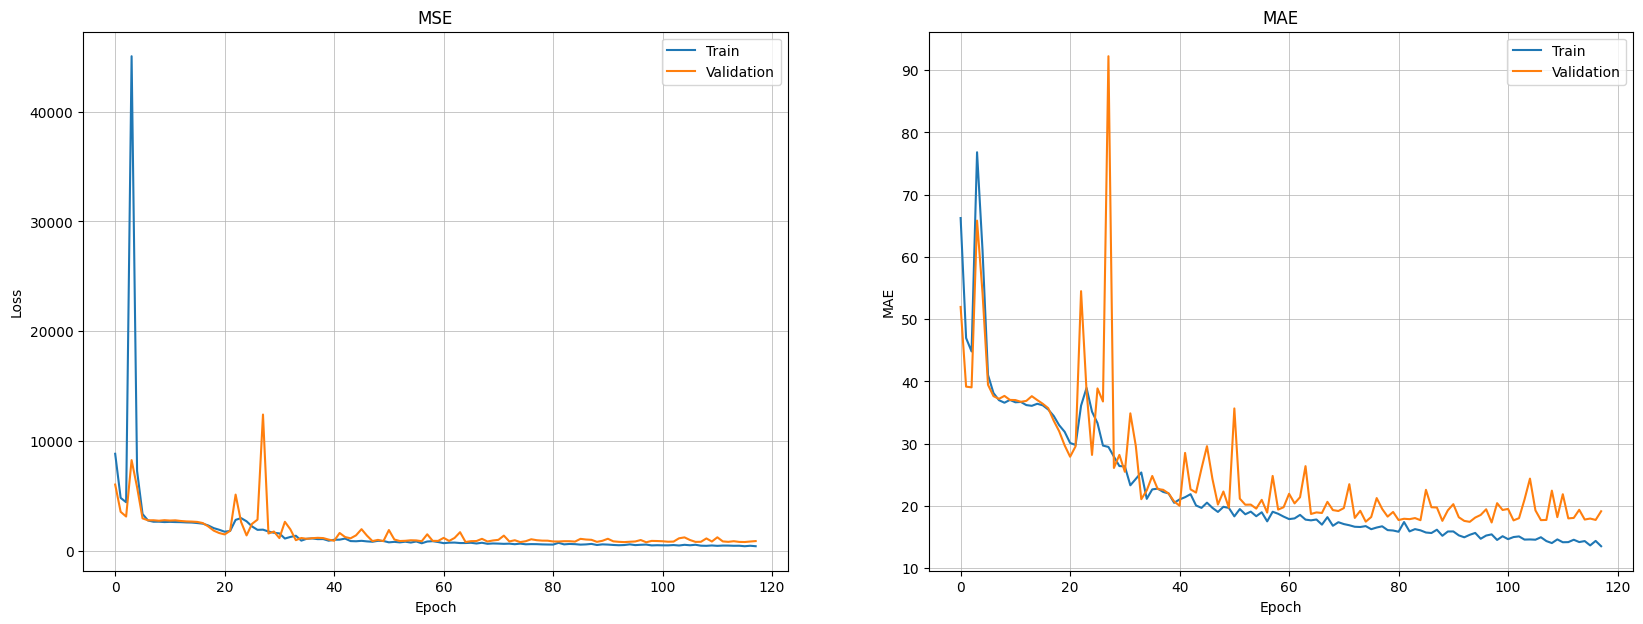

In [19]:
plot_history(history)

In [ ]:
y_val_pred=model.predict(X_val)

In [ ]:
y_val_pred.shape

### Prediction using 1st model

In [ ]:
y_pred=model.predict(X_to_predict)

In [ ]:
end_date=processed_data['Date'].max()
start_date=processed_data['Date'].min()
pred_dates=pd.date_range(start = end_date, end = end_date+datetime.timedelta(y_pred.shape[1]) )

In [ ]:
trafic_pred=pd.DataFrame(y_pred)

In [ ]:
def data_hist_predicted(y, y_pred, cells, start_date, end_date):

    end_date_2=end_date+datetime.timedelta(days=y_pred.shape[1])
    dates=pd.date_range(start = start_date, end = end_date_2)
    print (y.shape , y_pred.shape)
    # reshape the y to the 2d
    y_reshaped_2d=y
    y_reshaped_2d=y_reshaped_2d.reshape(-1, y.shape[1])
    print (y_reshaped_2d.shape)
    print (f"y shape 2d : {y_reshaped_2d.shape}")
    # convert y and y_pred to Dataframe
    list_y_pred=pd.DataFrame(y_pred)

    list_y=pd.DataFrame(y_reshaped_2d)
    cells=cells.reset_index(drop=True) # to be deleted after
    #concatenate y and y_pred and cell ids
    cell_data=pd.concat([list_y,list_y_pred],axis=1, ignore_index=True, sort=False)
    print (f"concatenation of y and y_pred : {cell_data.shape}")

    cell_data_final=pd.concat([cells,cell_data],axis=1, sort=False)
    # rename columns
    columns=['eNodeB identity','Cell ID','eNodeB_identifier_int']
    comunms_all=columns+(list(dates))
    cell_data_final.columns=comunms_all

    cell_data_final.set_index(['eNodeB identity','Cell ID','eNodeB_identifier_int'])

    # format the  dataframe to have dates as one column
    cell_data_final2=cell_data_final.melt(id_vars=['eNodeB identity','Cell ID','eNodeB_identifier_int'],
        var_name="Date",
        value_name="Trafic")
    cell_data_final2['Trafic'] = pd.to_numeric(cell_data_final2['Trafic'])
    # specify what are predicted and real dates

    cell_data_final2['Flag '] = ['Real' if x <= end_date else 'Predicted' for x in cell_data_final2['Date']]

    return cell_data_final2



In [ ]:
df_final=data_hist_predicted(cells_data_trafic, y_pred, cells, start_date, end_date)

In [ ]:
cells.shape

In [ ]:
df_final.shape

In [ ]:
df_final

### Second model

In [ ]:
def initialize_model_2(input_shape: tuple, output_length) -> models:
    #output_length = y_train.shape[1]
    #input_shape =(X.shape[1],X.shape[2])
    """
    Initialize the Neural Network with random weights
    """

    model = models.Sequential()
    ## 1.1 - Recurrent Layer
    model.add(layers.Masking(mask_value=-10, input_shape=input_shape))

    model.add(layers.GRU(units=64,
                        activation='relu',
                        return_sequences = True,
                        kernel_regularizer=L1L2(l1=0.05, l2=0.05),
                        ))
    #model.add(layers.GRU(64, activation='relu', return_sequences=False))

    #model.add(LSTM(32, activation='sigmoid', return_sequences=False))
    ## 1.2 - Hidden Dense Layers

    model.add(layers.Dense(128, activation="relu", kernel_regularizer = L1L2(l1=0.05, l2=0.05)))
    model.add(layers.Dense(64, activation="relu", kernel_regularizer = L1L2(l1=0.05, l2=0.05)))
    model.add(layers.Dropout(rate=0.5))


    ## 1.2 - Predictive Dense Layers

    model.add(layers.Dense(output_length, activation='linear'))

    return model


def compile_model_2(model: models) -> models:
    """
    Compile the Neural Network
    """

    # 2 - Compiler
    # ======================
    initial_learning_rate = 0.01

    #lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=1000, decay_rate=0.5)

    #adam = optimizers.Adam(learning_rate=initial_learning_rate)
    #model.compile(loss='mse', optimizer="adam", metrics=["mae"])
    model.compile(loss='mse', optimizer="rmsprop", metrics=['mae'])
    return model

def train_model_2(
        model: models,
        X: np.ndarray,
        y: np.ndarray,
        patience=2,
        validation_data=None, # overrides validation_split
        validation_split_rate=0.3
    ) -> Tuple[tensorflow.keras.Model, dict]:
    """
    Fit the model and return a tuple (fitted_model, history)
    """
     # $CHALLENGIFY_BEGIN
    es = EarlyStopping(monitor = "val_loss",
                      patience = patience,
                      mode = "min",
                      restore_best_weights = True)


    history = model.fit(X, y,
                        validation_data=validation_data,

                        batch_size = 16,
                        epochs = 500,
                        callbacks = [es],
                        verbose = 1)

    return model, history

In [ ]:
input_shape =(X_train.shape[1],X_train.shape[2])
output_length = y_train.shape[1]
model_2=initialize_model_2(input_shape, output_length)
model_2.summary()
model_2=compile_model_2(model)

In [ ]:
# train the model on all cells data
model_2_trained, history_2=train_model_2(
        model_2,
        X_train,
        y_train,
        20,
        (X_val, y_val), # don't use validation data, use validation split rate
        0.3
    )

In [ ]:
plot_history(history_2)

### train with 3rd model

In [ ]:
def initialize_model_3(input_shape: tuple, output_length) -> models:
    #output_length = y_train.shape[1]
    #input_shape =(X.shape[1],X.shape[2])
    """
    Initialize the Neural Network with random weights
    """

    model = models.Sequential()
    ## 1.1 - Recurrent Layer
    model.add(layers.Masking(mask_value=-10, input_shape=input_shape))
    model.add(layers.Masking(mask_value=0))
    model.add(layers.LSTM(units=64,
                        activation='relu',
                        return_sequences = False,
                        kernel_regularizer=L1L2(l1=0.05, l2=0.05),
                        ))
    #model.add(LSTM(32, activation='relu', return_sequences=True))
    #model.add(LSTM(16, activation='sigmoid', return_sequences=False))
    ## 1.2 - Hidden Dense Layers

    #model.add(layers.Dense(32, activation="relu", kernel_regularizer = L1L2(l1=0.05, l2=0.05)))
    #model.add(layers.Dropout(rate=0.5))


    ## 1.2 - Predictive Dense Layers

    model.add(layers.Dense(output_length, activation='linear'))

    return model


def compile_model_3(model: models) -> models:
    """
    Compile the Neural Network
    """

    # 2 - Compiler
    # ======================
    initial_learning_rate = 0.01

    #lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=1000, decay_rate=0.5)

    adam = optimizers.Adam(learning_rate=initial_learning_rate)

    model.compile(loss='mse', optimizer=adam, metrics=['mae'])
    return model

def train_model_3(
        model: models,
        X: np.ndarray,
        y: np.ndarray,
        patience=2,
        validation_data=None, # overrides validation_split
        validation_split_rate=0.3
    ) -> Tuple[tensorflow.keras.Model, dict]:
    """
    Fit the model and return a tuple (fitted_model, history)
    """
     # $CHALLENGIFY_BEGIN
    es = EarlyStopping(monitor = "val_loss",
                      patience = patience,
                      mode = "min",
                      restore_best_weights = True)


    history = model.fit(X, y,
                        validation_data=validation_data,
                        shuffle = False,
                        batch_size = 16,
                        epochs = 500,
                        callbacks = [es],
                        verbose = 1)

    return model, history

In [ ]:
input_shape =(X_train.shape[1],X_train.shape[2])
output_length = y_train.shape[1]
model_3=initialize_model_3(input_shape, output_length)
model_3.summary()
model_3=compile_model_3(model)

In [ ]:
# train the model on all cells data
model_3_trained, history_3=train_model_3(
        model_3,
        X_train,
        y_train,
        10,
        (X_val,y_val), # don't use validation data, use validation split rate
        0.3
    )

In [ ]:
plot_history(history_3)

### Model 4

In [ ]:
def initialize_model_4(input_shape: tuple, output_length) -> models:
    #output_length = y_train.shape[1]
    #input_shape =(X.shape[1],X.shape[2])
    """
    Initialize the Neural Network with random weights
    """

    model = models.Sequential()
    ## 1.1 - Recurrent Layer
    model.add(layers.Masking(mask_value=-10, input_shape=input_shape))
    #model.add(layers.Masking(mask_value=0))
    model.add(layers.LSTM(units=64,
                        activation='relu',
                        return_sequences = False,
                        kernel_regularizer=L1L2(l1=0.05, l2=0.05),
                        ))
    #model.add(LSTM(32, activation='relu', return_sequences=True))
    #model.add(LSTM(16, activation='sigmoid', return_sequences=False))
    ## 1.2 - Hidden Dense Layers

    #model.add(layers.Dense(32, activation="relu", kernel_regularizer = L1L2(l1=0.05, l2=0.05)))
    #model.add(layers.Dropout(rate=0.5))


    ## 1.2 - Predictive Dense Layers

    model.add(layers.Dense(output_length, activation='linear'))

    return model


def compile_model_4(model: models) -> models:
    """
    Compile the Neural Network
    """

    # 2 - Compiler
    # ======================


    model.compile(loss='mse', optimizer="rmsprop", metrics=['mae'])
    return model

def train_model_4(
        model: models,
        X: np.ndarray,
        y: np.ndarray,
        patience=2,
        validation_data=None, # overrides validation_split
        validation_split_rate=0.3
    ) -> Tuple[tensorflow.keras.Model, dict]:
    """
    Fit the model and return a tuple (fitted_model, history)
    """
     # $CHALLENGIFY_BEGIN
    es = EarlyStopping(monitor = "val_loss",
                      patience = patience,
                      mode = "min",
                      restore_best_weights = True)


    history = model.fit(X, y,
                        validation_data=validation_data,

                        batch_size = 16,
                        epochs = 500,
                        callbacks = [es],
                        verbose = 1)

    return model, history

In [ ]:
input_shape =(X_train.shape[1],X_train.shape[2])
output_length = y_train.shape[1]
model_4=initialize_model_4(input_shape, output_length)
model_4.summary()
model_4=compile_model_4(model)

In [ ]:
# train the model on all cells data
model_4_trained, history_4=train_model_4(
        model_4,
        X_train,
        y_train,
        10,
        (X_val,y_val), # don't use validation data, use validation split rate
        0.3
    )

In [ ]:
plot_history(history_3)

### Save X_train, y_train, X_test, y_test as csv files

In [ ]:
# Save X and y into csv files
file_path_X_train="/content/drive/MyDrive/X_train_all_5.csv"
file_path_y_train="/content/drive/MyDrive/y_train_all_5.csv"
file_path_X_test="/content/drive/MyDrive/X_test_all_5.csv"
file_path_y_test="/content/drive/MyDrive/y_test_all_5.csv"


with open(file_path_X_train, 'w', newline='') as csvfile_X_train:
    writer = csv.writer(csvfile_X_train, delimiter=',')
    writer.writerows(X_train_all_array_6)


In [ ]:
with open(file_path_y_train, 'w', newline='') as csvfile_y_train:
    writer = csv.writer(csvfile_y_train, delimiter=',')
    writer.writerows(y_train_all_array_6)

In [ ]:
with open(file_path_X_test, 'w', newline='') as csvfile_X_test:
    writer = csv.writer(csvfile_X_test, delimiter=',')
    writer.writerows(X_test_all_array_6)

In [ ]:
with open(file_path_y_test, 'w', newline='') as csvfile_y_test:
    writer = csv.writer(csvfile_y_test, delimiter=',')
    writer.writerows(y_test_all_array_6)

In [ ]:
#to read file you saved
file_path_X_train="/content/drive/MyDrive/X_train_all_5.csv"
file_path_y_train="/content/drive/MyDrive/y_train_all_5.csv"
file_path_X_test="/content/drive/MyDrive/X_test_all_5.csv"
file_path_y_test="/content/drive/MyDrive/y_test_all_5.csv"

with open(file_path_X_test, 'r') as f:
  reader = csv.reader(f)
  read_X_test = list(reader)


In [ ]:
read_X_test_array=np.array(read_X_test)
read_X_test_array.shape

### Export prediction to csv file

In [ ]:
# Save the real trafic and predicted trafic dataframe to csv file
file_final="~/code/Agermita/intelligent_network_expansion/raw_data/trafic_real_predict.csv"

df_final.to_csv(file_final)